# Evaluate the impact of the number of LSTM layer on attention

In [1]:
%load_ext autoreload
%autoreload 2

from IPython.display import display, HTML
import sys
sys.path.append("./../src")

In [79]:
import spacy
import pickle
import torch
import matplotlib.pyplot as plt

from data.collate import *
from data.archival_dataset import *
from data.pipeline import *
from helpers import hightlight_txt

from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

In [82]:
spacy_model = spacy.load('fr_core_news_md')
tokenizer = Tokenizer(spacy_model=spacy_model)
labels = ['neutral', 'entailment']
cache_path = '../src/_out'
data_path='../src/_out/dataset/archival'
nb_data = 9
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [59]:
vocab['red'].similarity(vocab['fly'])

AttributeError: 'int' object has no attribute 'similarity'

In [64]:
def visualize(lemma1, lemma2, attention1, attention2, pred, y_true):
    html = '<table>'
    html += '<tr> <th>Document 1</th> <th>Document 2</th><th>Prediction</th><th>Label</th> </tr>'
    for i in range(attention1.size(0)):
        html += '<tr> <td>' +  hightlight_txt(lemma1[i], attention1[i]) + '</td><td>' + hightlight_txt(lemma2[i], attention2[i]) +'</td><td>' + str(pred[i].item()) +'</td><td>' + str(y_true[i].item()) +'</td></tr>'
    html += '</table>'
    return html

In [83]:
testset = ArchivalDataset('test',cache_path='..\\src\\_out\\', shuffle=True, n=nb_data)
testset.data = testset.data[:nb_data].reset_index(drop=False)
testset.data['premise'] = ['.'.join(x.split('.')[:1]) for x in testset.data['premise']]
testset.data['hypothesis'] = ['.'.join(x.split('.')[:1]) for x in testset.data['hypothesis']]

vectorize_pipeline = SpacyVectorPipeline(spacy_model)
vocab = build_vocab(testset, vectors='', pipeline=text_pipeline, cache_path='..\\src\\_out\\')

num_pipeline = text_pipeline.numericalizer(vocab)

pad_vec = torch.tensor(spacy_model.vocab['<pad>'].vector)
collate_fn = SpacyLMCollate(padding=pad_vec, pipeline=vectorize_pipeline, multiclass=True, device=device)
test_iterator = DataLoader(testset, collate_fn=collate_fn, batch_size=nb_data, shuffle=False)

tokens1 = text_pipeline(testset.data['premise'])
tokens2 = text_pipeline(testset.data['hypothesis'])
testset.data

Load test: 100%|████████████| 1/1 [00:00<00:00, 12.05it/s, path=..\src\_out\dataset\archival\archival_dataset_test.csv]
Load vocab ..\src\_out\dataset\archival\vocab_standard.pkl: 100%|███████████████████████| 1/1 [00:00<00:00, 166.17it/s]


level_0  index  Unnamed: 0  \
0        0     23          23   
1        1     49          49   
2        2     83          83   
3        3      2           2   
4        4     33          33   
5        5     54          54   
6        6     75          75   
7        7     63          63   

                                             premise  \
0   [ | « elle s’ est comportée de la même manièr...   
1  Publication de « Sur l’ infantilisme « de gauc...   
2   Elle réagit donc à la nouvelle situation par ...   
3                                                      
4  sent un peu perdu , il voudrait être mis en re...   
5  Dans votre questionnaire c’ est le point III q...   
6  Litovsk ) , et sont remplacés par des « modéré...   
7  condamnation du « culte de la personnalité » (...   

                                          hypothesis    judgment  class  
0  L S { COMITE D' USINE | — — ; 1 Ÿ COMITE AUTRE...     neutral      0  
1   À lépoque , note Nettl , les communistes ne t...     neutral      0  
2   Dans son discours au Congrès de fondation du ...     neutral      0  
3  contre les modèles traditionnels de conflit à ...     neutral      0  
4   Il est vrai qu’ à ce moment -là , ils n’ en é...  entailment      1  
5   Du point de vue de « l’ orientation » de la r...  entailment      1  
6   Des détachements armés de la Tchéka font des ...  entailment      1  
7         Analysant la théorie politique de Marx , M  entailment      1

In [66]:
from model.attention_model import BetaModel

### 1BiLSTM

In [77]:
len(tokens1[0])

32

In [75]:
x1.size()

torch.Size([2, 32])

In [91]:
model_path = '..\\src\\_out\\models\\BetaModel.secondmodel\\best_model.pt'

model = BetaModel()
model = torch.load(model_path, map_location=torch.device('cpu'))

# Evaluation mode
model.eval()
with torch.no_grad():
    for x, y_true in test_iterator:
        y_hat, (a1v2, a2v1) = model(x)
        y_hat = torch.argmax(y_hat, dim=1)
        a2v1 = a2v1.squeeze(dim=1)
        a1v2 = a1v2.squeeze(dim=1)

toto ===> torch.Size([35, 300])


RuntimeError: The size of tensor a (300) must match the size of tensor b (0) at non-singleton dimension 1

In [18]:
text = visualize(tokens1, tokens2, a2v1, a1v2, y_hat, y_true)
display(HTML(text))

Plot attention values

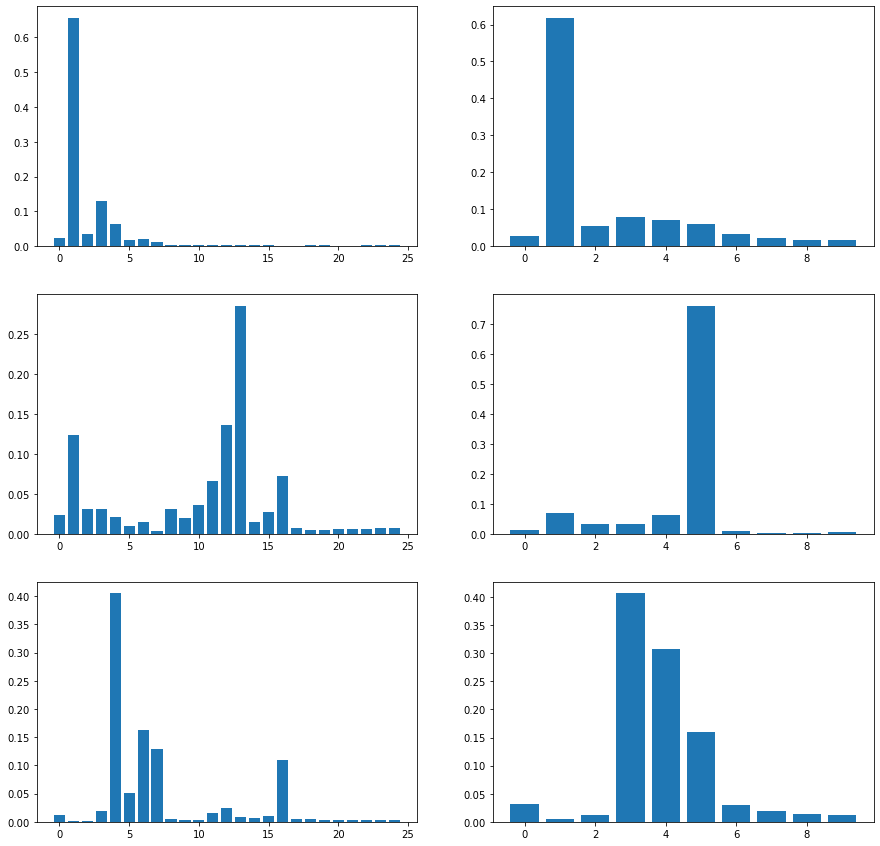

In [20]:
fig, ax = plt.subplots(3, 2, figsize=(15,15))

for i in range(3):
    ax[i][0].bar(range(a2v1[i].size(0)), a2v1[i].numpy())
    ax[i][1].bar(range(a1v2[i].size(0)), a1v2[i].numpy())

### 2biLSTM

In [10]:
model_path = '/Users/dunguyen/Projects/IGRIDA/historic/2021-06-10/models/MulticlassMetaModel.2bilstm/best_model.pt'

model = MulticlassMetaModel(n_lstm=1, bidirectional=True)
model = torch.load(model_path, map_location=torch.device('cpu'))

# Evaluation mode
model.eval()
with torch.no_grad():
    for x1, x2, y_true in test_iterator:
        y_hat, (a1v2, a2v1) = model(x1, x2)
        y_hat = torch.argmax(y_hat, dim=1)
        a2v1 = a2v1.squeeze(dim=1)
        a1v2 = a1v2.squeeze(dim=1)

In [11]:
# TODO: inversed role a2 and a1
text = visualize(tokens1, tokens2, a2v1, a1v2, y_hat, y_true)
display(HTML(text))

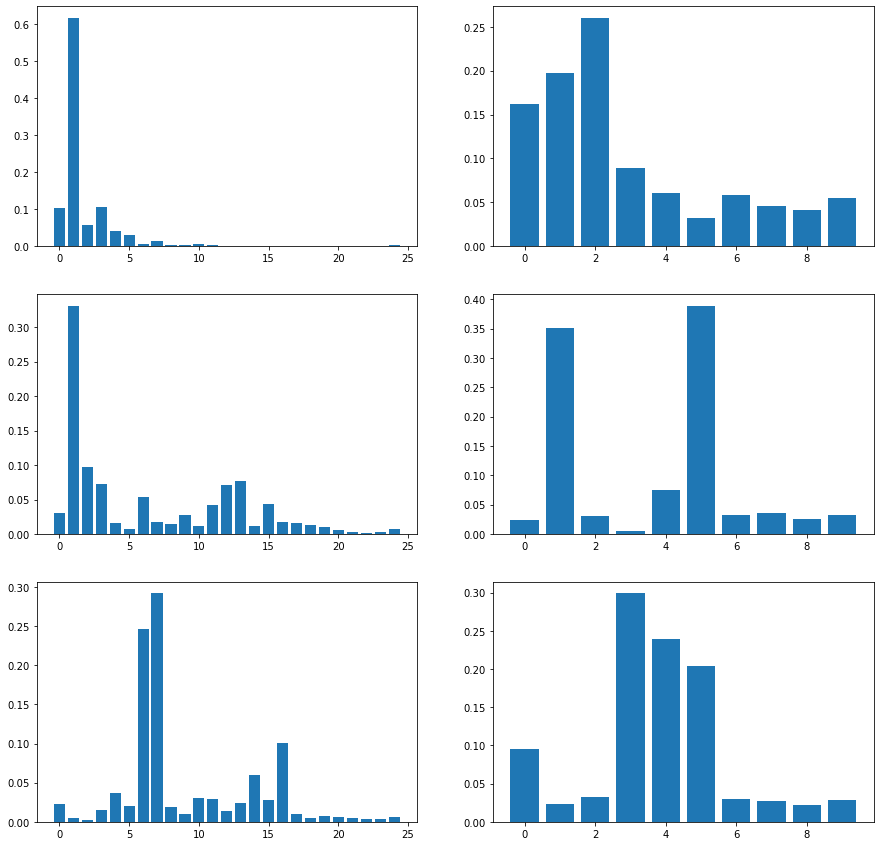

In [12]:
fig, ax = plt.subplots(3, 2, figsize=(15,15))

for i in range(3):
    ax[i][0].bar(range(a2v1[i].size(0)), a2v1[i].numpy())
    ax[i][1].bar(range(a1v2[i].size(0)), a1v2[i].numpy())

# 3 biLSTM

In [13]:
model_path = '/Users/dunguyen/Projects/IGRIDA/historic/2021-06-10/models/MulticlassMetaModel.3bilstm/best_model.pt'

model = MulticlassMetaModel(n_lstm=1, bidirectional=True)
model = torch.load(model_path, map_location=torch.device('cpu'))

# Evaluation mode
model.eval()
with torch.no_grad():
    for x1, x2, y_true in test_iterator:
        y_hat, (a1v2, a2v1) = model(x1, x2)
        y_hat = torch.argmax(y_hat, dim=1)
        a2v1 = a2v1.squeeze(dim=1)
        a1v2 = a1v2.squeeze(dim=1)

In [14]:
# TODO: inversed role a2 and a1
text = visualize(tokens1, tokens2, a2v1, a1v2, y_hat, y_true)
display(HTML(text))

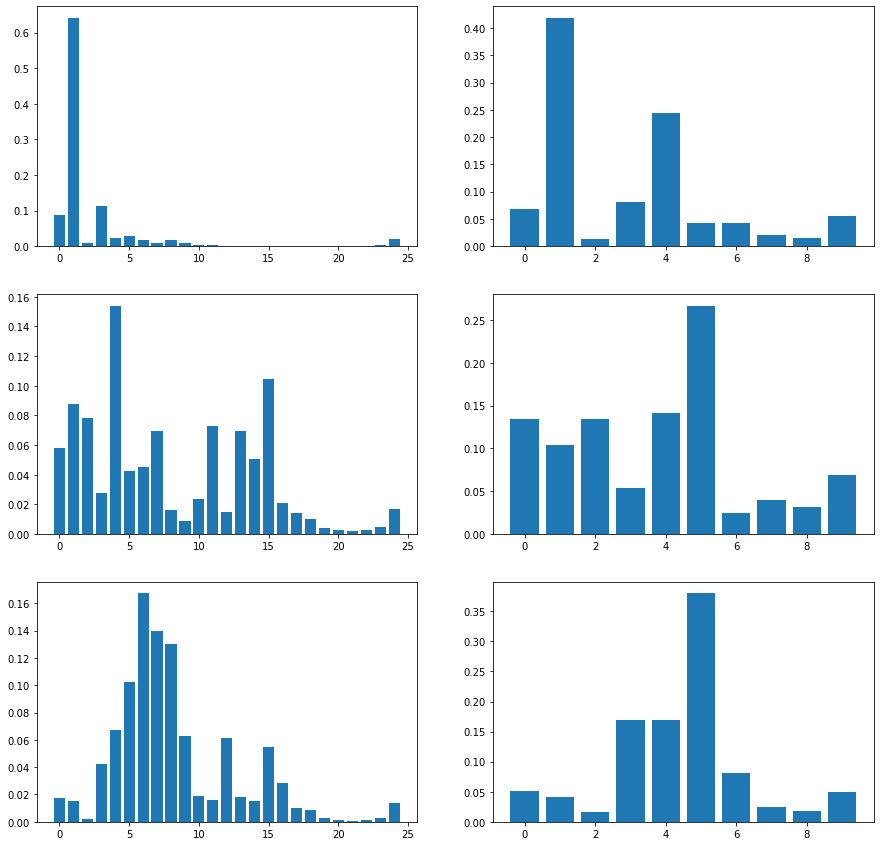

In [15]:
fig, ax = plt.subplots(3, 2, figsize=(15,15))

for i in range(3):
    ax[i][0].bar(range(a2v1[i].size(0)), a2v1[i].numpy())
    ax[i][1].bar(range(a1v2[i].size(0)), a1v2[i].numpy())

# Statistic of SNLI

In [40]:
cache_path = '../src/_out'
data_path='_out/dataset/snli'
cache_path = "..\\src\\_out\\"
testset2 = SNLIDataset(split='test', cache_path=cache_path)
testset2.data

Load test: 100%|█████████████████████████████████| 1/1 [00:00<00:00, 38.41it/s, path=..\src\_out\dataset\snli\test.csv]


index                                            premise  \
0         0  This church choir sings to the masses as they ...   
1         1  This church choir sings to the masses as they ...   
2         2  This church choir sings to the masses as they ...   
3         3  A woman with a green headscarf, blue shirt and...   
4         4  A woman with a green headscarf, blue shirt and...   
...     ...                                                ...   
9819   9995        Two women are observing something together.   
9820   9996        Two women are observing something together.   
9821   9997  A man in a black leather jacket and a book in ...   
9822   9998  A man in a black leather jacket and a book in ...   
9823   9999  A man in a black leather jacket and a book in ...   

                                          hypothesis       judgment  class  
0              The church has cracks in the ceiling.        neutral      0  
1                    The church is filled with song.     entailment      1  
2                A choir singing at a baseball game.  contradiction      2  
3                                The woman is young.        neutral      0  
4                           The woman is very happy.     entailment      1  
...                                              ...            ...    ...  
9819  Two women are standing with their eyes closed.  contradiction      2  
9820             Two girls are looking at something.     entailment      1  
9821                         A man is flying a kite.  contradiction      2  
9822               A man is speaking in a classroom.     entailment      1  
9823       A man is teaching science in a classroom.        neutral      0  

[9824 rows x 5 columns]

0